In [1]:
## 마운트 ##
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div style = "height: 50px;"></div>

# 필요한 모듈 불러오기

In [3]:
import os, math, warnings

import pandas            as pd
import matplotlib.pyplot as plt
import numpy             as np
import tensorflow        as tf

from glob                        import glob
from PIL                         import Image
from skimage.io                  import imread
from skimage.transform           import resize
from tensorflow.keras.models     import *
from tensorflow.keras.layers     import *
from tensorflow.keras.optimizers import *
from albumentations              import HorizontalFlip, \
                                          RandomSizedCrop, \
                                          Compose, \
                                          OneOf, \
                                          Resize

from keras import backend as K
from keras.regularizers import l2

In [4]:
warnings.simplefilter("ignore")

<div style = "height: 50px;"><div/>

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 1</span> : KITTI 데이터셋 수집과 구축

- Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용예
-  imgaug의 Sometimes()와 유사한 기능

## 1. 데이터 불러오기
<hr/>

In [12]:
def build_augmentation(is_train = True):
    # 훈련용 데이터일 경우
    if is_train:
        return Compose([HorizontalFlip  (p = 0.5), # 50%의 확률로 좌우대칭
                         
                        RandomSizedCrop(min_max_height = (300, 370), 
                                          w2h_ratio    = 370 / 1242,
                                          height       = 224,
                                          width        = 224,
                                          p            = 0.5), # 50%의 확률로 RandomSizedCrop
                        
                        Resize          (width = 224, height = 224)])
    
    return Compose([Resize(width = 224, height = 224)])

In [20]:
dir_path = '/content/drive/MyDrive/00.AIFFEL/02.Going Deeper/8. 도로 영역을 찾자_Unet++/data/training'

In [21]:
augmentation_train = build_augmentation()
augmentation_test  = build_augmentation(is_train = False)
input_images       = glob(os.path.join(dir_path, 'image_2', '*.png'))

<div style = "height: 25px;"><div/>

### 데이터 augmentation 적용 시각화

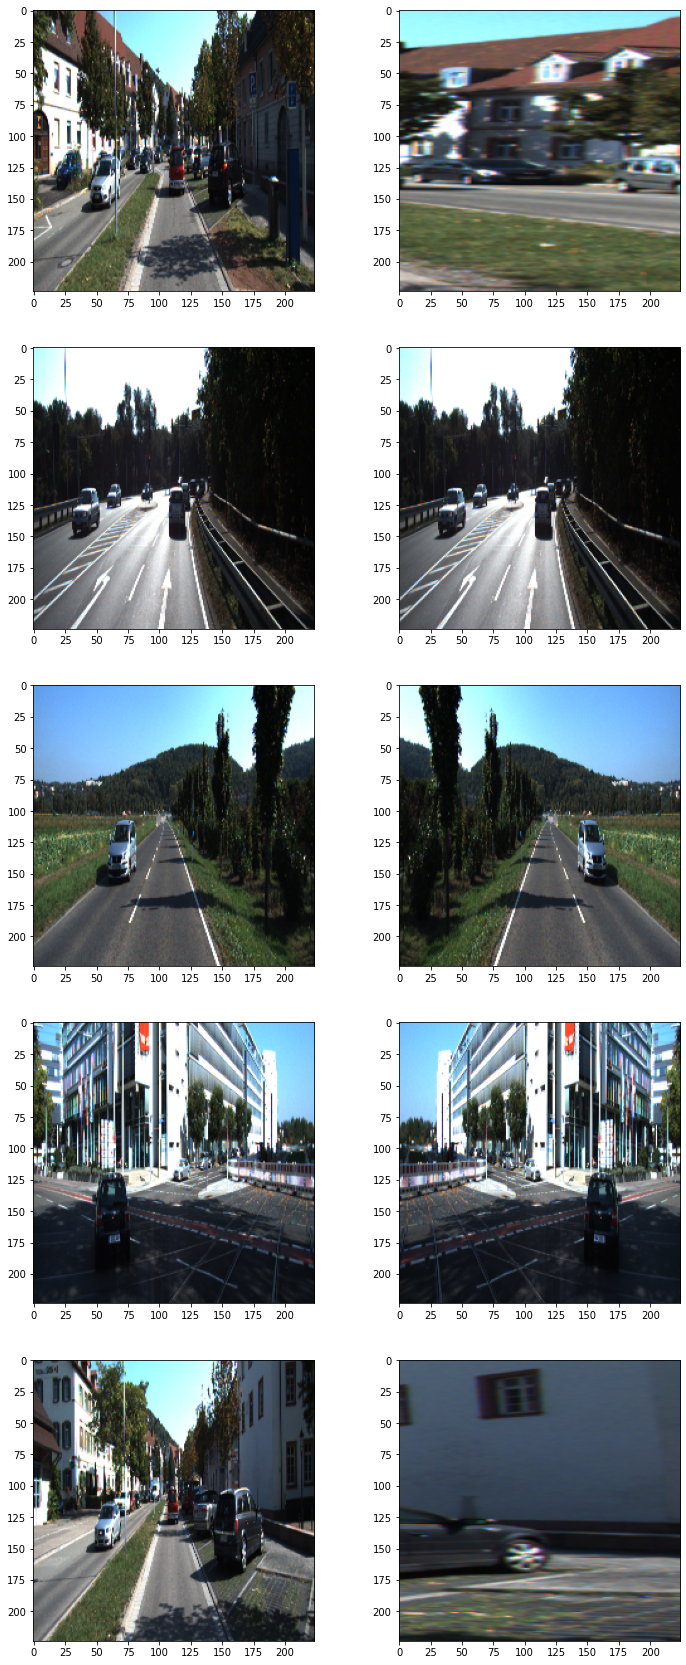

In [23]:
# 5개만 가져와 augmentation 적용해보기
plt.figure(figsize = (12, 30))
for i in range(5):
    image      = imread(input_images[i])
    image_data = {'image' : image}
    resized    = augmentation_test(**image_data)
    processed  = augmentation_train(**image_data)
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized['image']) # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed['image']) # 오른쪽이 augment된 이미지
plt.show()

<div style = "height: 50px;"><div/>

## 2. 데이터셋 구축하기
<hr/>

- 데이터셋을 구성
- tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성

In [24]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path, 
                 batch_size   = 16, 
                 img_size     = (224, 224, 3), 
                 output_size  = (224, 224), 
                 is_train     = True, 
                 augmentation = None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path     = dir_path
        self.batch_size   = batch_size
        self.is_train     = is_train
        self.dir_path     = dir_path
        self.augmentation = augmentation
        self.img_size     = img_size
        self.output_size  = output_size
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        
        return data[-30:]
      
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index * self.batch_size:
                               (index + 1) * self.batch_size
                               ]
        inputs  = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            
            _input     = imread(input_img_path)
            _output    = imread(output_path)
            _output    = (_output==7).astype(np.uint8) * 1
            data       = {"image": _input, "mask": _output}
            augmented  = self.augmentation(**data)
            inputs[i]  = augmented["image"]/255
            outputs[i] = augmented["mask"]
            
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        
        if self.is_train == True :
            np.random.shuffle(self.indexes)   
            return self.indexes

In [25]:
augmentation    = build_augmentation()
test_preproc    = build_augmentation(is_train=False)       
train_generator = KittiGenerator(dir_path, augmentation=augmentation)
test_generator  = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 2</span> : U-Net 모델 구현

## 1. 모델 구조 만들기
<hr/>

In [1]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
  
    #Contracting Path
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv5)
    
    
    
    
    #Expanding Path
    drop5  = Dropout(0.5)(conv5)
    
    up6    = Conv2DTranspose(512, 2, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge6)
    conv6  = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv6)
    
    up7    = Conv2DTranspose(256, 2, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge7)
    conv7  = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv7)
    
    up8    = Conv2DTranspose(128, 2, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge8)
    conv8  = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv8)
    
    up9    = Conv2DTranspose(64, 2, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9  = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(merge9)
    conv9  = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv9)  
    conv9  = Conv2D(2, 3,  activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv9)     
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
  
    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
model_path = 'data/training/seg_model_unet.h5' 

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

In [41]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                      

<div style = "height: 50px;"><div/>

## 2. 모델 학습하기
<hr/>

In [ ]:
# model.fit(
#      train_generator,
#      validation_data=test_generator,
#      steps_per_epoch=len(train_generator),
#      epochs=100,
#  )

# model.save(model_path)  #학습한 모델을 저장해 주세요.

실수로 런타임 모두 실행을하여, 기록이 날라갔으나, 학습 할 때 저장한 모델이 있으므로 이를 불러와 실행하고자 한다.

<div style = "height: 50px;"><div/>

## 3. 모델 훈련 결과 시각화
<hr/>

In [ ]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
  
    #Contracting Path
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv5)
    
    
    
    
    #Expanding Path
    drop5  = Dropout(0.5)(conv5)
    
    up6    = Conv2DTranspose(512, 2, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(512, 3, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(merge6)
    conv6  = Conv2D(512, 3, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv6)
    
    up7    = Conv2DTranspose(256, 2, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(256, 3, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(merge7)
    conv7  = Conv2D(256, 3, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv7)
    
    up8    = Conv2DTranspose(128, 2, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(128, 3, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(merge8)
    conv8  = Conv2D(128, 3, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv8)
    
    up9    = Conv2DTranspose(64, 2, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9  = Conv2D(64, 3, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(merge9)
    conv9  = Conv2D(64, 3, activation = 'relu', strides = (2,2), kernel_initializer = 'he_normal')(conv9)  
    conv9  = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
  
    model = Model(inputs = inputs, outputs = conv10)
    return model

In [40]:
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록 모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들어주세요!

이때 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(overray) 해 주세요. PIL 패키지를 사용하신다면 Image.blend를 활용하실 수 있습니다.

In [54]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path) # imread로 이미지 받기
    data       = {"image" : origin_img}
    processed  = preproc(**data)
    output     = model(np.expand_dims(processed["image"]/255,axis=0))
    output     = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output     = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output     = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output     = Image.blend(background, output, alpha=0.5)
    
    output.show()
    return output 

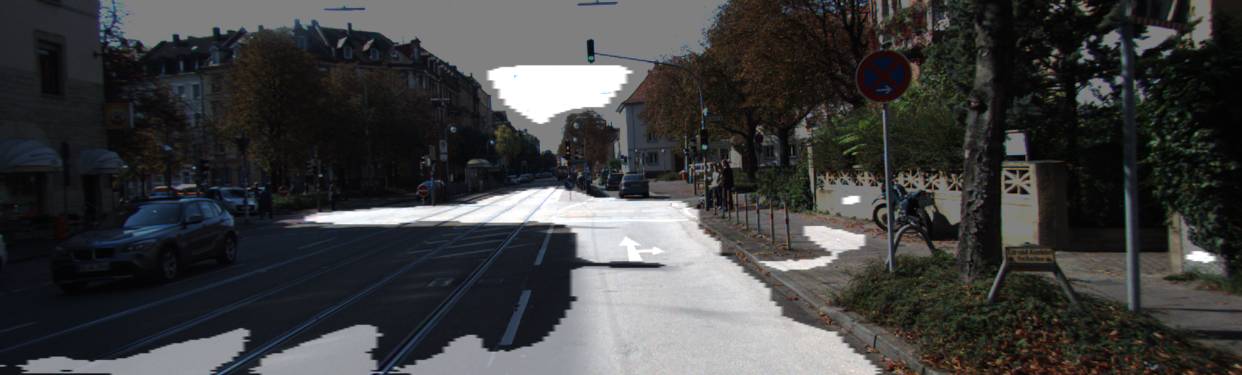

In [29]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path  = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path = dir_path + f'./result_{str(i).zfill(3)}.png'
 )

<div style = "height: 50px;"><div/>

## 4. IoU 출력해보기
<hr/>

IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 각각을 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현해 보겠습니다. 위에 구현했던 get_output을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현

In [30]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union        = np.logical_or(target, prediction)
    iou_score    = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [31]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data       = {"image":origin_img}
    processed  = preproc(**data)
    output     = model(np.expand_dims(processed["image"]/255,axis=0))
    output     = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255  # 도로로 판단한 영역
    
    output     = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output     = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output     = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화
     
    if label_path:   
        label_img       = imread(label_path)
        label_data      = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target          = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [32]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path  = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path = dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path  = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 3</span> : U-Net++ 모델 구현

## 1. 모델 구조 만들기
<hr/>

In [37]:
def build_unet_plus_model(input_shape = (224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting Path
    conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)
    
    conv5  = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    
    
    
    # Re-designed skip pathways
    # conv1_1
    up_conv2        = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2.shape[1], up_conv2.shape[2]))
    merge1_1        = concatenate([skip_crop_conv1, up_conv2])
    conv1_1         = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge1_1)
    conv1_1         = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1_1)
    
    # conv2_1
    up_conv3        = Conv2D(128, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv3))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3.shape[1], up_conv3.shape[2]))
    merge2_1        = concatenate([skip_crop_conv2 , up_conv3])
    conv2_1         = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge2_1)
    conv2_1         = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2_1)
    
    # conv3_1
    up_conv4        = Conv2D(256, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv4))
    skip_crop_conv3 = tf.image.resize(conv3, (up_conv4.shape[1], up_conv4.shape[2]))
    merge3_1        = concatenate([skip_crop_conv3, up_conv4])
    conv3_1         = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge3_1)
    conv3_1         = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3_1)
    
    # conv1_2
    up_conv2_1        = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv2_1))
    skip_crop_conv1   = tf.image.resize(conv1,   (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    merge1_2          = concatenate([skip_crop_conv1, skip_crop_conv1_1, up_conv2_1])
    conv1_2           = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge1_2)
    conv1_2           = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1_2)
    
    # conv2_2
    up_conv3_1        = Conv2D(256, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv3_1))
    skip_crop_conv2   = tf.image.resize(conv2,   (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    skip_crop_conv2_1 = tf.image.resize(conv2_1, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    merge2_2          = concatenate([skip_crop_conv2, skip_crop_conv2_1, up_conv3_1])
    conv2_2           = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge2_2)
    conv2_2           = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2_2)

    # conv1_3
    up_conv2_2        = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv2_2))
    skip_crop_conv1   = tf.image.resize(conv1,   (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_2 = tf.image.resize(conv1_2, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    merge1_3          = concatenate([skip_crop_conv1, skip_crop_conv1_1, skip_crop_conv1_2, up_conv2_2])
    conv1_3           = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge1_3)
    conv1_3           = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1_3)
    
    
    
    
    # Expansive path
    up1    = Conv2D(512, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(batch5)) 
    merge1 = concatenate([conv4, up1])
    conv6  = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge1)
    conv6  = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv6)

    up2          = Conv2D(256, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv6))
    crop_conv3   = tf.image.resize(conv3,   (up2.shape[1], up2.shape[2]))
    crop_conv3_1 = tf.image.resize(conv3_1, (up2.shape[1], up2.shape[2]))
    merge2       = concatenate([crop_conv3, crop_conv3_1, up2])
    conv7        = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge2)
    conv7        = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv7)

    up3          = Conv2D(128, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv7))
    crop_conv2   = tf.image.resize(conv2,   (up3.shape[1], up3.shape[2]))
    crop_conv2_1 = tf.image.resize(conv2_1, (up3.shape[1], up3.shape[2]))
    crop_conv2_2 = tf.image.resize(conv2_2, (up3.shape[1], up3.shape[2]))
    merge3       = concatenate([crop_conv2, crop_conv2_1, crop_conv2_2, up3])
    conv8        = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge3)
    conv8        = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv8)

    up4          = Conv2D(64, 2, activation = "relu", padding = "same", kernel_initializer = "he_normal")(UpSampling2D(size = (2, 2))(conv8))
    crop_conv1   = tf.image.resize(conv1,   (up4.shape[1], up4.shape[2]))
    crop_conv1_1 = tf.image.resize(conv1_1, (up4.shape[1], up4.shape[2]))
    crop_conv1_2 = tf.image.resize(conv1_2, (up4.shape[1], up4.shape[2]))
    crop_conv1_3 = tf.image.resize(conv1_3, (up4.shape[1], up4.shape[2]))
    merge4       = concatenate([crop_conv1, crop_conv1_1, crop_conv1_2, crop_conv1_3, up4])
    conv9        = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge4)
    conv9        = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)
    conv9        = Conv2D(2,  3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)
    
    conv10 = Conv2D(1, 1, activation = "sigmoid")(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [44]:
model_path = '/content/drive/MyDrive/00.AIFFEL/02.Going Deeper/8. 도로 영역을 찾자_Unet++/data/training/seg_model_unet_plus_plus.h5' 

unet_plus = build_unet_plus_model()
unet_plus.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

In [45]:
unet_plus.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_151 (Conv2D)            (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_152 (Conv2D)            (None, 224, 224, 64  36928       ['conv2d_151[0][0]']             
                                )                                                           

<div style = "height: 50px;"><div/>

## 2. 모델 학습하기
<hr/>

### 에러 발생

In [43]:
unet_plus.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_plus.save(model_path)

Epoch 1/100


ResourceExhaustedError: ignored

배치사이즈를 줄여 실행하여 이를 해결하고자 한다.

<div style = "height: 25px;"><div/>

### 배치사이즈 조정

In [46]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path, 
                 batch_size=8, 
                 img_size=(224, 224, 3), 
                 output_size=(224, 224), 
                 is_train=True, 
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        
        return data[-30:]
      
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index * self.batch_size:
                               (index + 1) * self.batch_size
                               ]
        inputs  = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            
            _input     = imread(input_img_path)
            _output    = imread(output_path)
            _output    = (_output==7).astype(np.uint8) * 1
            data       = {"image": _input, "mask": _output}
            augmented  = self.augmentation(**data)
            inputs[i]  = augmented["image"]/255
            outputs[i] = augmented["mask"]
            
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)   
            return self.indexes

In [47]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(dir_path, augmentation=augmentation)
test_generator = KittiGenerator(dir_path, augmentation=test_preproc, is_train=False)

<div style = "height: 25px;"><div/>

### 모델 학습 진행

In [48]:
unet_plus.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_plus.save(model_path)

Epoch 1/100
22/22 [==============================] - 54s 2s/step - loss: 0.2495 - val_loss: 0.0759
Epoch 2/100
22/22 [==============================] - 33s 2s/step - loss: 0.0699 - val_loss: 0.0735
Epoch 3/100
22/22 [==============================] - 34s 2s/step - loss: 0.0456 - val_loss: 0.0456
Epoch 4/100
22/22 [==============================] - 33s 2s/step - loss: 0.0566 - val_loss: 0.0545
Epoch 5/100
22/22 [==============================] - 33s 2s/step - loss: 0.0453 - val_loss: 0.0441
Epoch 6/100
22/22 [==============================] - 33s 2s/step - loss: 0.0379 - val_loss: 0.0516
Epoch 7/100
22/22 [==============================] - 33s 2s/step - loss: 0.0531 - val_loss: 0.0936
Epoch 8/100
22/22 [==============================] - 33s 2s/step - loss: 0.0403 - val_loss: 0.0473
Epoch 9/100
22/22 [==============================] - 33s 2s/step - loss: 0.0376 - val_loss: 0.0473
Epoch 10/100
22/22 [==============================] - 33s 2s/step - loss: 0.0391 - val_loss: 0.0390
Epoch 11/

<div style = "height: 50px;"><div/>

## 3. 모델 훈련 결과 시각화
<hr/>

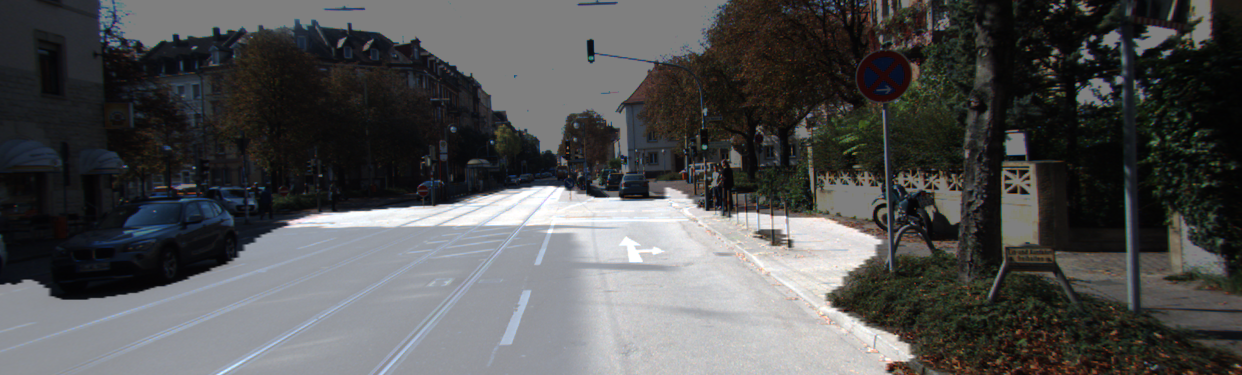

In [56]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

<div style = "height: 50px;"><div/>

## 4. IoU 출력해보기
<hr/>

In [51]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.872650


0.8726495726495727

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 4</span> : 결과 비교하기

## 1. 결과 시각화
<hr/>

<img src = "img/result.png">

<div style = "height: 50px;"><div/>

## 2. IoU 비교
<hr/>

<table style = "width:80%; margin:auto; border:0.5px solid #c1c1c1; font-size:15px;">
    <th style = "width:50%; padding:10px; text-align:center; border:0.5px solid #c1c1c1;">U-Net</th>
    <th style = "width:50%; padding:10px; text-align:center; border:0.5px solid #c1c1c1;">U-Net++</th>
    <tr>
        <td style = "padding:10px; text-align:center; border:0.5px solid #c1c1c1;">IoU : 0.419641</td>
        <td style = "padding:10px; text-align:center; border:0.5px solid #c1c1c1;">IoU : 0.872650</td>
    </tr>


</table>

<div style = "height: 50px;"></div>

# <span style = "font-weight:bold;color:#0172d4;">STEP 5</span> : 회고

## 1. 이해에 도움이 된 링크
<hr/>

<ul>
    <li style = "margin-bottom:14px;"><a href = "https://wsshin.tistory.com/2">U-Net++ 논문 리뷰 블로그</a></li>
    <li style = "margin-bottom:14px;"><a href = "https://www.kaggle.com/code/ekhtiar/tf-tutorial-semantic-segmentation-with-u-net/notebook">캐글 U-Net++ keras로 구현(19번 셀)</a></li>
</ul>

<div style = "height: 50px;"></div>